In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.VMS import *
from VMSfunctions.Common import Peak

# Generate fake Peaks

In [5]:
from VMSfunctions.Common import load_obj
from VMSfunctions.DataGenerator import PeakSampler

In [30]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50)

# Scanning Methods

In [7]:
class Dataset_Scan(object):
    def __init__(self,dataset,ms1_window_range,rt,ms_level):
        if ms_level == 2:
            self.scan_result = [None] * len(dataset.ms1_names)
            for dataset_index in range(0,len(dataset.peaks)):
                if dataset.peaks[dataset_index].ms_level==2: # this needs changing to be MS1 as MS2 wouldnt be known
                    dataset.peaks[dataset_index].get(ms_level,rt,ms1_window_range)
                    self.scan_result[dataset.ms2_names.index(dataset.peaks[dataset_index])] = dataset.peaks[dataset_index].in_range
        else:
            print("this doesn't work yet!")

In [34]:
import math
class Dia_Basic(object):
    def __init__(self,dataset,num_windows,window_type,ms1_range=[[None],[None]],range_slack=0.01):
        self.locations = []
        self.scan_results = []
        # if no ms1_range provided, initialise the scan range from dataset
        if ms1_range==[[None],[None]]:
            ms1_range_difference = dataset.ms1_range[1][0] - dataset.ms1_range[0][0]
            ms1_range = [[dataset.ms1_range[0][0] - range_slack*ms1_range_difference],[dataset.ms1_range[1][0] + range_slack*ms1_range_difference]]
        else:
            ms1_range_difference = ms1_range[1][0] - ms1_range[0][0] 
        # Look at whether components are within the different isolation windows
        if window_type=="even":
            for window_index in range(0,num_windows):
                ms1_window_range = [[ms1_range[0][0] + window_index*((ms1_range_difference * (1 + 2*range_slack))/num_windows)],[ms1_range[0][0] + (window_index+1)*((ms1_range_difference * (1 + 2*range_slack))/num_windows)]]
                self.locations.append(ms1_window_range)
                self.scan_results.append(Dataset_Scan(dataset,ms1_window_range,0,2).scan_result)
        elif window_type=="percentile":
            dataset.ms1_values()
            adjusted_percentiles = np.percentile(dataset.ms1_values,range(0,100 + int(100/num_windows),int(100/num_windows))).tolist()
            adjusted_percentiles[0] = adjusted_percentiles[0] - range_slack*ms1_range_difference
            adjusted_percentiles[-1] = adjusted_percentiles[-1] + range_slack*ms1_range_difference
            for window_index in range(0,num_windows):
                ms1_window_range = [[adjusted_percentiles[window_index]],[adjusted_percentiles[window_index+1]]]
                self.locations.append(ms1_window_range)
                self.scan_results.append(Dataset_Scan(dataset,ms1_window_range,0,2).scan_result)
        else:
            sys.exit("Incorrect window_type specified")
        self.ms1_names = dataset.ms1_names
        self.ms2_names = dataset.ms2_names
        
    def bin_walls(self):
        self.bin_walls = list(set(sum(sum(d1.locations,[]),[])))
    
    def location_all(self):
        self.location_all = []
        for i in range(0,len(self.ms1_names)):
            found=False
            j=0
            while found==False:
                if self.scan_results[j][i]==1:
                    self.location_all.append(self.locations[j])
                    found=True
                else:
                    j+=1  
            
    def entropy(self):
        self.location_all()
        entropy_vec = []
        for i in range(0,len(self.locations)):
            entropy_vec.extend([0])
            for j in range(0,len(self.ms1_names)):
                if self.locations[i]==self.location_all[j]:
                    entropy_vec[i] +=1
        entropy_vec_nozero = [value for value in entropy_vec if value != 0]
        self.entropy = sum([math.log(y) for y in entropy_vec_nozero])
        self.entropy_vec = entropy_vec

In [35]:
d1 = Dia_Basic(m,10,"even")
d1.entropy()
d2 = Dia_Basic(m,10,"percentile")
d2.entropy()
print(d1.entropy_vec)
print(d2.entropy_vec)
print(d1.entropy)
print(d2.entropy)


TypeError: 'list' object is not callable

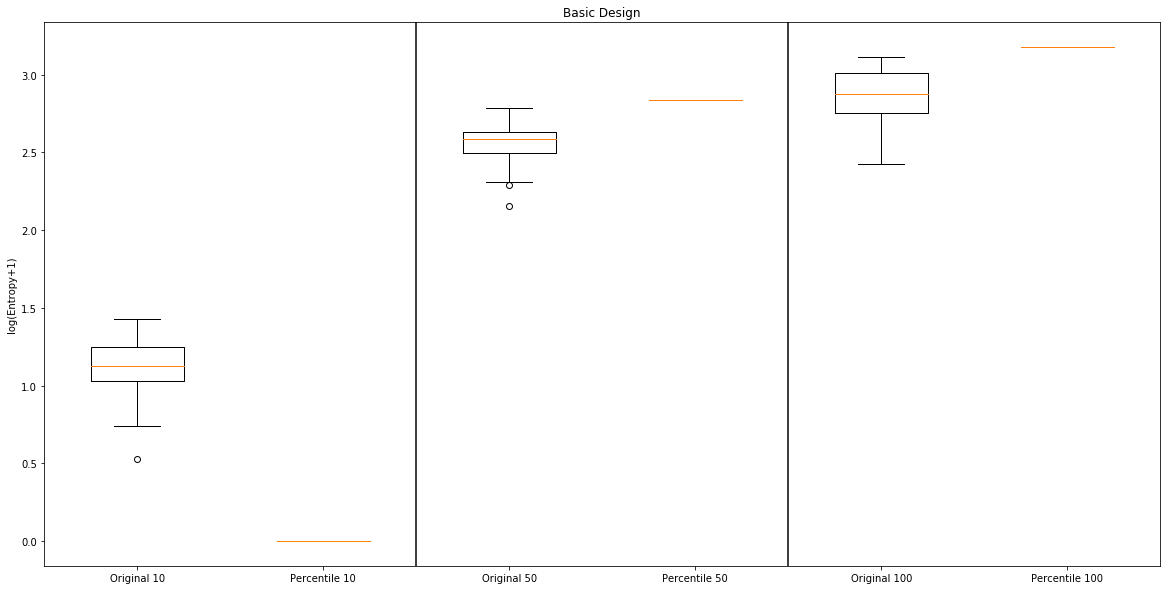

In [25]:
test1_result = []
test2_result = []
test3_result = []
test4_result = []
test5_result = []
test6_result = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100)
    test1=Dia_Basic(Data_test1,10,"even")
    test2=Dia_Basic(Data_test1,10,"percentile")
    test3=Dia_Basic(Data_test2,10,"even")
    test4=Dia_Basic(Data_test2,10,"percentile")
    test5=Dia_Basic(Data_test3,10,"even")
    test6=Dia_Basic(Data_test3,10,"percentile")
    test1.entropy()
    test2.entropy()
    test3.entropy()
    test4.entropy()
    test5.entropy()
    test6.entropy()
    test1_result.append(math.log(test1.entropy+1))
    test2_result.append(math.log(test2.entropy+1))
    test3_result.append(math.log(test3.entropy+1))
    test4_result.append(math.log(test4.entropy+1))
    test5_result.append(math.log(test5.entropy+1))
    test6_result.append(math.log(test6.entropy+1))
    
test_result = [test1_result,test2_result,test3_result,test4_result,test5_result,test6_result]

plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result)
plt.ylabel("log(Entropy+1)")
plt.title("Basic Design")
plt.xticks([1,2,3,4,5,6],["Original 10","Percentile 10","Original 50","Percentile 50","Original 100","Percentile 100"])
plt.show()